In [1]:
from training.model import *
from training.datasets import *
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
BASE_DIR = ''
BATCH_SIZE = 100
test_checkpoint = 'checkpoints/PlaqueTissueClassifier_Epoch_0.pth'
plaque_dir = BASE_DIR + "tiles"

In [ ]:
model = PlaqueTissueClassifier().to('cpu')
checkpoint_path = os.path.join(BASE_DIR, test_checkpoint)
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# handles if model was parallelized during training
new_state_dict = dict()
for k, v in checkpoint['model_state_dict'].items():
    name = k.replace('module.', '') # remove `module.`
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),

    # Normalize for pretrained weights
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

plaque_holdout_set = PlaqueDataset(os.path.join(plaque_dir, 'hold-out.csv'), os.path.join(plaque_dir, 'hold-out'), transform=test_transform)
plaque_holdout_loader = DataLoader(plaque_holdout_set, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
def plaque_roc(model, plaque_loader, class_names, device):
    # init metrics
    probabilities = []
    labels = []

    # Plaque inference
    for p_data in plaque_loader:
        # Run inference on batch
        p_images, p_labels = p_data[0].to(device,dtype=torch.float), p_data[1].to(device,dtype=torch.long)
        p_preds, _ = model(p_images)
        # get class probabilities
        probabilities.append(torch.nn.functional.sigmoid(p_preds.data).cpu().numpy())
        labels.append(p_labels.cpu().numpy())
    
    probabilities = np.concatenate(probabilities)
    labels = np.concatenate(labels)

    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(len(class_names)):
        fpr[class_names[i]], tpr[class_names[i]], _ = roc_curve(labels[:, i], probabilities[:, i])
        roc_auc[class_names[i]] = auc(fpr[class_names[i]], tpr[class_names[i]])
    
    return fpr, tpr, roc_auc


In [5]:
def plot_roc(fpr, tpr):
    plt.figure()
    for key in fpr:
        plt.plot(fpr[key], tpr[key], label=f"ROC of class {key}")
    
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic for Plaque Holdout")
    plt.legend(loc="lower right")
    plt.show()

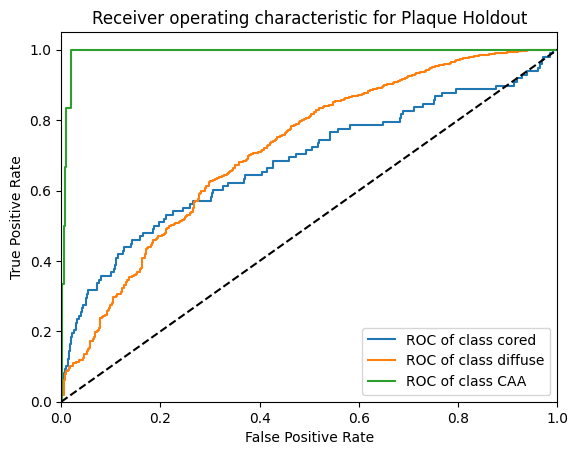

Class cored AUROC = 0.6809470145366732
Class diffuse AUROC = 0.7166091233999573
Class CAA AUROC = 0.9923621974786049


In [6]:
fpr, tpr, auc_roc = plaque_roc(model, plaque_holdout_loader, ['cored', 'diffuse', 'CAA'], 'cpu')
plot_roc(fpr, tpr)
for key in auc_roc:
    print(f"Class {key} AUROC = {auc_roc[key]}")